In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import svm
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR)

# Import dataset
* import data from train / predict csv file
* transfer Revenue/click into RPC

In [2]:
train_set = pd.read_csv("train.csv", delimiter=",", parse_dates=True)
predict_set = pd.read_csv("prediction.csv", delimiter=",", parse_dates=True)
feature_list = ["Keyword_ID","Ad_group_ID","Campaign_ID","Account_ID","Device_ID","Match_type_ID"]
train_set["RPC"] = train_set["Revenue"].values/train_set["Clicks"].values

# Check raw data
Result from the below:
* Features has no NaN values
* The features are partly overlapped 

In [3]:
train_set[list(predict_set)].astype(str).describe()

,Date,Keyword_ID,Ad_group_ID,Campaign_ID,Account_ID,Device_ID,Match_type_ID
count,8285423,8285423,8285423,8285423,8285423,8285423,8285423
unique,115,487981,269480,2927,16,3,3
top,2015-01-17,981509692733,428124648205,919168440848,604905316813,298643508640,95725474456
freq,281063,5188,8111,325658,2300896,3980401,3754784


In [4]:
predict_set.astype(str).describe()

,Date,Keyword_ID,Ad_group_ID,Campaign_ID,Account_ID,Device_ID,Match_type_ID
count,578012,578012,578012,578012,578012,578012,578012
unique,7,195748,118978,2259,16,3,3
top,2015-04-09,981509692733,501719917851,919168440848,604905316813,298643508640,95725474456
freq,90792,359,519,23375,176184,283650,264997


In [5]:
# check the key words etc are overlapped or not 
for feature in feature_list:
    t = set(train_set[feature].values)
    p = set(predict_set[feature].values)
    print(feature,"in predict is subset in train:",p.issubset(t))

Keyword_ID in predict is subset in train: False
Ad_group_ID in predict is subset in train: False
Campaign_ID in predict is subset in train: False
Account_ID in predict is subset in train: True
Device_ID in predict is subset in train: True
Match_type_ID in predict is subset in train: True


In [6]:
# check no null data inside the train/prediction set 
print("check train set isnull :\n",train_set.isnull().any())
print("check predict set isnull: \n",predict_set.isnull().any())

check train set isnull :
 Date             False
Keyword_ID       False
Ad_group_ID      False
Campaign_ID      False
Account_ID       False
Device_ID        False
Match_type_ID    False
Revenue          False
Clicks           False
Conversions      False
RPC              False
dtype: bool
check predict set isnull: 
 Date             False
Keyword_ID       False
Ad_group_ID      False
Campaign_ID      False
Account_ID       False
Device_ID        False
Match_type_ID    False
dtype: bool


# Imbalanced dataset

If do not do upsample / downsample, the model will bias to the majority ones those without revenues

In this assigment,simply returning 0 for all the inputs could reach 98% correctness. This is obviously wrong.

From the test blow we can't be so sure what is the best porportion for revenue vs non-revenue, since the error is no longer smaller the better


* downsample the majority type
* upsample the minority type

In [7]:
# unbalanced dataset
revenue = train_set[train_set["RPC"]>0].shape[0]
no_revenue= train_set[train_set["RPC"] == 0].shape[0]
print("Revenue",revenue)
print("No revenue",no_revenue)
print('Unbalanced dataset for revenue portion',(revenue/(revenue+no_revenue)))

Revenue 160649
No revenue 8124774
Unbalanced dataset for revenue portion 0.019389354049877718


In [8]:
"""  
- keep all the minority dataset  
- downsample from the rest of majority dataset 
The problem here:
    We might sample the bias majority prediction, losing important information for zero-revenue part.
"""
def balanced_dataset(major_portion,df):
    train_minor = df[df["Revenue"] > 0]
    minor_size = train_minor.shape[0]
    train_major = df[df["Revenue"] == 0].sample(n=minor_size*major_portion)
    balanced_set = pd.concat([train_major, train_minor]).sample(frac = 1.0)
    print('New balanced dataset revenue portion is:',train_minor.shape[0]/balanced_set.shape[0])
    return balanced_set

In [10]:
"""
Test on different revenue proportion with simple linear regression
"""
for portion in range(1,6):
    balanced_set = balanced_dataset(portion,train_set)
    X = balanced_set[feature_list]
    y = balanced_set['RPC']
    clf = LinearRegression()
    error_list= []
    for _ in range(6):
        x_train, x_validate, y_train, y_validate = train_test_split(X,y,test_size=0.2,shuffle=True)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_validate)
        error = np.sqrt(metrics.mean_squared_error(y_validate, y_pred))
        error_list.append(error)
    print("RMSE",sum(error_list)/len(error_list),"\n",error_list)

New balanced dataset revenue portion is: 0.5
RMSE 3298.360783391489 
 [3133.0743912363396, 3258.196270135476, 3765.649474937612, 2966.517535499931, 3399.0610471182035, 3267.665981421369]
New balanced dataset revenue portion is: 0.3333333333333333
RMSE 2792.6950797058275 
 [2811.844434846364, 2687.1671026818303, 2735.649999767808, 3194.342030105784, 2681.039830449805, 2646.127080383377]
New balanced dataset revenue portion is: 0.25
RMSE 2501.040632407004 
 [2365.946348824716, 2755.8406000794753, 2407.979587151054, 2473.8162038259097, 2247.1384106369032, 2755.5226439239646]
New balanced dataset revenue portion is: 0.2
RMSE 2267.0538457265598 
 [2054.802269050211, 2085.712377865449, 2501.4641259292757, 2147.2887688018077, 2495.0086069723206, 2318.046925740294]
New balanced dataset revenue portion is: 0.16666666666666666
RMSE 2071.9955812682742 
 [2049.0301550490435, 2371.2611849072737, 1946.3336773814083, 1902.0940301952123, 2056.314209516797, 2106.9402305599124]


# Preprocess category feature 
### Scikit-Learn 
* OneHotEncoder:

    The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. 
    The output will be a sparse matrix where each column corresponds to one possible value of one feature. It is assumed that input features take on values in the range \[0, n_values)


* LabelEncoder: 

    A utility class to help normalize labels such that they contain only values between 0 and n_classes-1

! Problem : 
    Use OneHotEncoder or LabelEncoder in large dataset(billions of text tags) could slow down the convert


### Pandas
* factorize:

    Label those the hashed features and return continuous numeric tags represent different hash code

! Problem :
    For each feature those data are not real continuous numbers

In [11]:
"""
Category feature in Pandas:
"""
def category_in_pandas(df,feature_list):
    train_category = df
    train_category[feature_list] = df[feature_list].apply(lambda x : pd.factorize(x)[0])
    train_category[feature_list].astype(str).describe()
    return train_category
category_in_pandas(train_set,feature_list).astype(str).describe()

,Date,Keyword_ID,Ad_group_ID,Campaign_ID,Account_ID,Device_ID,Match_type_ID,Revenue,Clicks,Conversions,RPC
count,8285423,8285423,8285423,8285423,8285423,8285423,8285423,8285423,8285423,8285423,8285423
unique,115,487981,269480,2927,16,3,3,10907,255,45,30184
top,2015-01-17,28,240,3,7,0,0,0.0,2,0,0.0
freq,281063,5188,8111,325658,2300896,3980401,3754784,8124774,6510187,8123396,8124774


In [12]:
def regession(clf,X,y,test_size=0.2,shuffle=True):
    x_train, x_validate, y_train, y_validate = train_test_split(X,y,test_size=test_size,shuffle=shuffle)
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_validate)
    print("RMSE",np.sqrt(metrics.mean_squared_error(y_validate, y_pred)))

In [13]:
category_set = category_in_pandas(balanced_set,feature_list)
X,y = category_set[feature_list],category_set['RPC']
clf = LinearRegression()
for _ in range(5):
    regession(clf,X,y,test_size=0.2,shuffle=True)

RMSE 1872.7391633816183
RMSE 2060.077294219344
RMSE 2295.499594305379
RMSE 1897.4320596887217
RMSE 2129.8499058744824


In [14]:
"""
prepare data set
"""
balanced_set = balanced_dataset(6,train_set)
X,y = balanced_set[feature_list],balanced_set['RPC']

New balanced dataset revenue portion is: 0.14285714285714285


In [18]:
"""
Category feature in OneHotEncoder
"""
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X)
# encoder.active_features_
# encoder.transform(X)
x_code_train = encoder.transform(x_train)
x_code_validate = encoder.transform(x_validate)

clf = LinearRegression()
clf.fit(x_code_train,y_train)
y_pred=clf.predict(x_code_validate)
print("RMSE",np.sqrt(metrics.mean_squared_error(y_validate, y_pred)))

RMSE 1907.8318035057887


In [16]:
"""
Category feature in LabelEncoder on feature_list
"""
def create_label_encoder(df):
    le = LabelEncoder()
    new_X = pd.DataFrame()
    for head in list(df):
        new_X[head] = le.fit_transform(df[head])
    return new_X

new_X = create_label_encoder(X)

clf = LinearRegression()
for _ in range(5):
    x_train, x_validate, y_train, y_validate = train_test_split(new_X,y,test_size=0.2,shuffle=True)
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_validate)
    print("RMSE",np.sqrt(metrics.mean_squared_error(y_validate, y_pred)))

RMSE 2138.3278915921196
RMSE 1867.2334088621135
RMSE 1818.793464146461
RMSE 1768.104573138274
RMSE 1766.2322373775003


## Using TensorFlow
* numeric_column+GradientDescentOptimizer+LinearRegressor


In [19]:
def my_input_fn(features, targets, batch_size=50, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=5000)
    return ds.make_one_shot_iterator().get_next()


def train_model(df,learning_rate, steps, batch_size):
    """
    numeric_column+GradientDescentOptimizer+LinearRegressor
    """
    periods = 10
    steps_per_period = steps / periods
    
    input_feature = ['Keyword_ID']#,'Ad_group_ID'
    bucket_size = [487981] #,269480
    my_feature_column = df[input_feature]
    targets = df["RPC"]

    feature_columns = []
    for feature,bucket in zip(input_feature,bucket_size):
        categorical_feature = tf.feature_column.numeric_column(feature)
        feature_columns.append(categorical_feature)
#         categorical_feature = tf.feature_column.categorical_column_with_identity(key=feature, num_buckets=bucket, default_value=0)
#         feature_columns.append(tf.feature_column.embedding_column(categorical_feature,math.ceil(bucket**0.25)))
    
    # Create input functions
    training_input_fn = lambda:my_input_fn(my_feature_column,targets,batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_column,targets,num_epochs=1)
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    #     my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns,optimizer=my_optimizer)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    for period in range (0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print(("  period %02d : %0.2f") % (period, root_mean_squared_error))
    print("Model training finished.")

In [26]:
# input data 
balanced_set = balanced_dataset(6,train_set)
category_set = category_in_pandas(balanced_set,feature_list)
print(category_set.shape)
train_model(balanced_set,learning_rate=0.001,steps=200,batch_size=1000)

New balanced dataset revenue portion is: 0.14285714285714285
(1124543, 11)
Training model...
RMSE (on training data):
  period 00 : 1935.73
  period 01 : 1935.73
  period 02 : 2005.84
  period 03 : 1935.73
  period 04 : 2004.67
  period 05 : 1935.73
  period 06 : 1935.73
  period 07 : 2004.53
  period 08 : 2005.28
  period 09 : 1935.73
Model training finished.


#### Compared with all those above different approches
raw data + LabelEncoder + LinearRegression from 

New balanced dataset revenue portion is: 0.16666666666666666
RMSE 1995.1941323015783
New balanced dataset revenue portion is: 0.14285714285714285
RMSE 2190.773711071997
New balanced dataset revenue portion is: 0.125
RMSE 1748.564367011215
New balanced dataset revenue portion is: 0.1111111111111111
RMSE 1634.8047197832377
New balanced dataset revenue portion is: 0.1
RMSE 1583.5438036439093


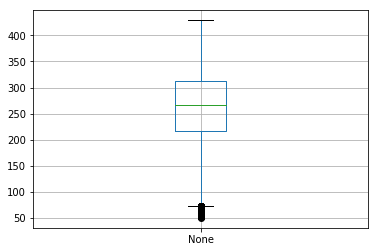

distribution  count    578011.000000
mean        264.062135
std          68.143324
min          50.293344
25%         217.312879
50%         267.529078
75%         312.869430
max         428.998002
dtype: float64


In [97]:
train_set = pd.read_csv("train.csv", delimiter=",", parse_dates=True)
predict_set = pd.read_csv("prediction.csv", delimiter=",", parse_dates=True)
feature_list = ["Keyword_ID","Ad_group_ID","Campaign_ID","Account_ID","Device_ID","Match_type_ID"]
train_set["RPC"] = train_set["Revenue"].values/train_set["Clicks"].values

for major_portion in range(5,10):
    balanced_set = balanced_dataset(major_portion,train_set)
    X,y = balanced_set[feature_list],balanced_set['RPC']
    Z = pd.concat([X, predict_set[feature_list]])
    
    le = LabelEncoder()
    new_Z = pd.DataFrame()
    for head in list(Z):
        new_Z[head] = le.fit_transform(Z[head])

    new_X = new_Z.iloc[0:X.shape[0],]
    new_predict = new_Z.iloc[X.shape[0]:-1,]

    clf = LinearRegression()
    for _ in range(35):
        x_train, x_validate, y_train, y_validate = train_test_split(new_X,y,test_size=0.2,shuffle=True)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_validate)
    print("RMSE",np.sqrt(metrics.mean_squared_error(y_validate, y_pred)))

    prediction = clf.predict(new_predict)

result = pd.Series(prediction)
result.plot.box()
plt.grid(True)
plt.show()

print("distribution ",result.describe())
result.to_csv("result.csv",index=False,header=False)